In [1]:
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

import nltk
nltk.download('stopwords', quiet=True)
nltk.download('wordnet',   quiet=True)
nltk.download('omw-1.4',    quiet=True)
nltk.download('punkt',     quiet=True)
nltk.download('punkt_tab', quiet=True)

True

In [2]:
import pandas as pd
import re

from nltk.corpus       import stopwords
from nltk.stem         import WordNetLemmatizer
from nltk.tokenize     import word_tokenize


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection       import train_test_split
from sklearn.naive_bayes           import MultinomialNB
from sklearn.metrics               import (
    accuracy_score, classification_report, confusion_matrix
)

import matplotlib.pyplot as plt
import seaborn as sns
from rapidfuzz import process, fuzz

In [ ]:
df = pd.read_csv('bbc-text.csv')
print(f"Data loaded: {df.shape[0]} rows, {df.shape[1]} columns")
print(df['category'].value_counts())

 Veri yüklendi: 2225 satır, 2 sütun
category
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64


In [ ]:
# Cell 4: Vocabulary creation (raw tokens + stopwords)
stop_words = set(stopwords.words('english'))

raw_tokens = set()
for doc in df['text']:
    cleaned = re.sub(r'[^a-zA-Z\s]', '', doc.lower())
    raw_tokens.update(cleaned.split())

vocab = list(raw_tokens | stop_words)
print(f"Vocabulary created: {len(vocab)} tokens.")

 Vocabulary oluşturuldu: 30389 token.


In [ ]:
# Cell 5: Typo correction function using RapidFuzz
from rapidfuzz import process, fuzz

def correct_word(token, max_dist=1):
    """
    1) If the word is already in vocab, return as is.
    2) For tokens with 4 or fewer characters, check for single character transposition (e.g., teh → the).
    3) For longer tokens, use ratio-based best match within max_dist length difference.
    """
    # 1) If already correct, return
    if token in vocab:
        return token

    # 2) For short tokens, try single swap
    if len(token) <= 4:
        for i in range(len(token)-1):
            swapped = token[:i] + token[i+1] + token[i] + token[i+2:]
            if swapped in vocab:
                return swapped

    # 3) Ratio-based correction for longer tokens
    candidates = [w for w in vocab if abs(len(w) - len(token)) <= max_dist]
    if not candidates:
        return token

    result = process.extractOne(
        token,
        candidates,
        scorer=fuzz.ratio,
        score_cutoff=60
    )
    if result:
        best, score, _ = result
        return best

    return token

In [ ]:
# ─── Cell 6: Preprocessing + typo correction ───
lemmatizer = WordNetLemmatizer()
stop_words  = set(stopwords.words('english'))

def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r'[^a-zA-Z\s]', '', text, flags=re.I|re.A)
    text = text.lower()
    tokens = word_tokenize(text)

    processed_tokens = []
    for tok in tokens:
        if tok in stop_words:
            continue
        lemma = lemmatizer.lemmatize(tok)
        # Only correct if not in vocab
        if lemma not in vocab:
            lemma = correct_word(lemma, max_dist=1)
        processed_tokens.append(lemma)

    return " ".join(processed_tokens)

In [7]:
# Hücre 7 
from tqdm.notebook import tqdm
tqdm.pandas()

df['processed_text'] = df['text'].progress_apply(preprocess_text)

  0%|          | 0/2225 [00:00<?, ?it/s]

In [8]:
print(correct_word("goverment"))   # → government
print(correct_word("conssole"))    # → console
print(correct_word("teh"))         # → the

government
console
the


In [ ]:
tfidf = TfidfVectorizer(
    ngram_range=(1,2),
    max_features=5000,
    stop_words='english'
)
X_tfidf = tfidf.fit_transform(df['processed_text'])
y       = df['category']

print("TF-IDF matrix shape:", X_tfidf.shape)
print("Example features:", tfidf.get_feature_names_out()[:20])

TF-IDF matrisi shape: (2225, 5000)
Örnek feature’lar: ['aaa' 'abandoned' 'abc' 'ability' 'able' 'abn' 'abortion' 'abroad'
 'absence' 'absolute' 'absolutely' 'abuse' 'abused' 'ac' 'academy'
 'academy award' 'accept' 'acceptable' 'accepted' 'access']


In [ ]:
# 10) Train/Test split (also split original text)
from sklearn.model_selection import train_test_split


X_train, X_test, \
y_train, y_test, \
raw_train, raw_test = train_test_split(
    X_tfidf,           # Our TF-IDF matrix
    y,                 # labels
    df['text'],        # original raw text
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"✅ Train/Test split complete (X_train: {X_train.shape}, X_test: {X_test.shape})")

✅ Train/Test split tamam (X_train: (1780, 5000), X_test: (445, 5000))


In [ ]:
# Cell 11: Train & Evaluate First Baseline Model (MultinomialNB)
model = MultinomialNB()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred))

Accuracy: 0.9820
               precision    recall  f1-score   support

     business       0.98      0.96      0.97       102
entertainment       0.99      1.00      0.99        77
     politics       0.98      0.96      0.97        84
        sport       1.00      1.00      1.00       102
         tech       0.96      0.99      0.98        80

     accuracy                           0.98       445
    macro avg       0.98      0.98      0.98       445
 weighted avg       0.98      0.98      0.98       445



In [ ]:
# Cell 14: Train/Test Split
X = df['processed_text']
y = df['category']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Train: {X_train.shape[0]} / Test: {X_test.shape[0]}")

Train: 1780 / Test: 445


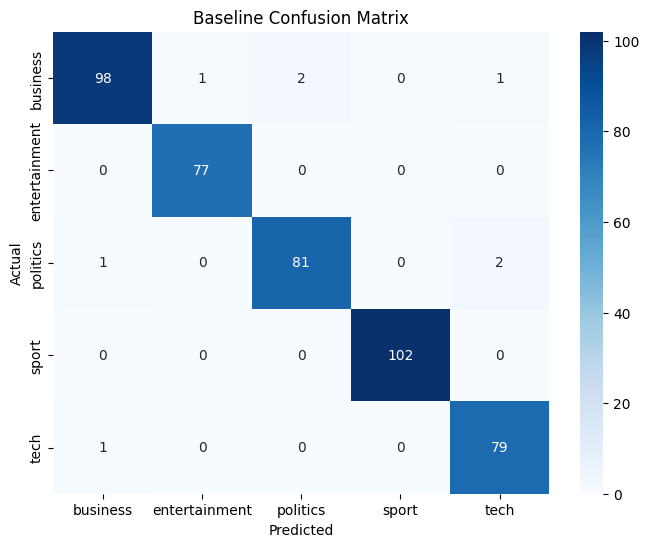

In [13]:
# Hücre 12: Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
plt.figure(figsize=(8,6))
sns.heatmap(
    cm, annot=True, fmt='d',
    xticklabels=model.classes_,
    yticklabels=model.classes_,
    cmap='Blues'
)
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Baseline Confusion Matrix')
plt.show()

In [14]:
# Hücre 13: Pipeline’ları Tanımla
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

pipe_nb = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), max_features=5000, stop_words='english')),
    ("clf", MultinomialNB())
])

pipe_lr = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), max_features=5000, stop_words='english')),
    ("clf", LogisticRegression(max_iter=1000))
])

In [15]:
# Hücre 14: Pipeline için Yeni Train/Test Split (processed_text ile)
X2 = df['processed_text']
y2 = df['category']
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=0.2, random_state=42, stratify=y2
)
print(f"Train: {X2_train.shape[0]} / Test: {X2_test.shape[0]}")

Train: 1780 / Test: 445


In [16]:
# Hücre 15: Pipeline’ları Eğit & Karşılaştır
pipe_nb.fit(X2_train, y2_train)
y2_nb = pipe_nb.predict(X2_test)
acc_nb = accuracy_score(y2_test, y2_nb)

pipe_lr.fit(X2_train, y2_train)
y2_lr = pipe_lr.predict(X2_test)
acc_lr = accuracy_score(y2_test, y2_lr)

print(f"✅ NB Pipeline Accuracy:  {acc_nb:.4f}")
print(f"✅ LR Pipeline Accuracy:  {acc_lr:.4f}")

✅ NB Pipeline Accuracy:  0.9775
✅ LR Pipeline Accuracy:  0.9843


In [17]:
# Hücre 16: Hiperparametre Optimizasyonu
from sklearn.model_selection import GridSearchCV

gs_nb = GridSearchCV(pipe_nb, {"clf__alpha":[0.1,0.5,1.0]}, cv=3, n_jobs=-1)
gs_nb.fit(X2_train, y2_train)
print("NB best alpha:", gs_nb.best_params_, "→", gs_nb.best_score_)

gs_lr = GridSearchCV(pipe_lr, {"clf__C":[0.01,0.1,1,10]}, cv=3, n_jobs=-1)
gs_lr.fit(X2_train, y2_train)
print("LR best C:", gs_lr.best_params_, "→", gs_lr.best_score_)

NB best alpha: {'clf__alpha': 0.1} → 0.9719132490352277
LR best C: {'clf__C': 10} → 0.9741598105847684


Best Model Accuracy: 0.9842696629213483
               precision    recall  f1-score   support

     business       0.98      0.97      0.98       102
entertainment       0.99      1.00      0.99        77
     politics       0.98      0.96      0.97        84
        sport       1.00      1.00      1.00       102
         tech       0.98      0.99      0.98        80

     accuracy                           0.98       445
    macro avg       0.98      0.98      0.98       445
 weighted avg       0.98      0.98      0.98       445



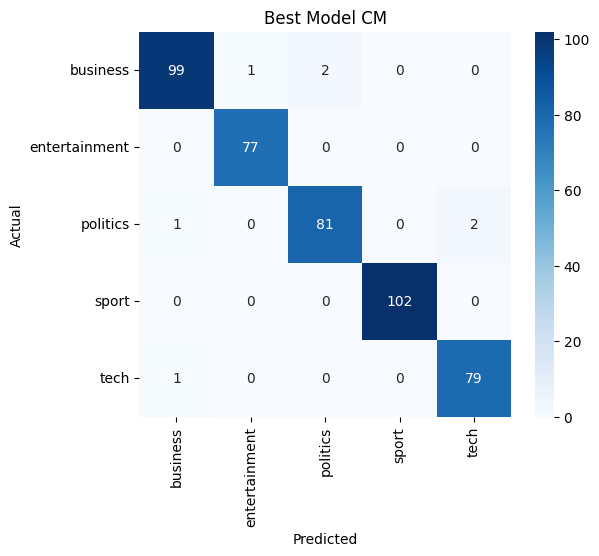

In [18]:
# Hücre 17: En İyi Modelin Performansı
best_model = gs_lr.best_estimator_
y_best = best_model.predict(X2_test)
print("Best Model Accuracy:", accuracy_score(y2_test, y_best))
print(classification_report(y2_test, y_best))

cm2 = confusion_matrix(y2_test, y_best, labels=best_model.classes_)
plt.figure(figsize=(6,5))
sns.heatmap(cm2, annot=True, fmt='d',
            xticklabels=best_model.classes_,
            yticklabels=best_model.classes_,
            cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Best Model CM')
plt.show()

In [19]:
# Hücre 18: Hatalı Sınıflandırma Örnekleri
errors = X2_test[y2_test != y_best]
true_l = y2_test[y2_test != y_best]
pred_l = y_best[y2_test != y_best]
for txt, t, p in zip(errors[:10], true_l[:10], pred_l[:10]):
    print(f"▶ True: {t:13s} | Pred: {p:13s}\n   {txt[:100]}...\n")

▶ True: business      | Pred: politics     
   saudi ministry employ woman woman employed saudi arabia foreign ministry first time year foreign min...

▶ True: business      | Pred: politics     
   call overhaul uk state pension uk pension system branded inadequate complex leading retirement think...

▶ True: tech          | Pred: business     
   china ripe medium explosion asia set drive global medium growth beyond china india filling two top s...

▶ True: politics      | Pred: business     
   drive save festive holiday effort made protect worker day christmas day new year day support sought ...

▶ True: politics      | Pred: tech         
   mp issued blackberry threat mp thrown common use blackberry chamber speaker michael martin ruled han...

▶ True: business      | Pred: entertainment
   mcdonald sponsor mtv show mcdonald world largest restaurant chain sponsor programme music channel mt...

▶ True: politics      | Pred: tech         
   mp issued blackberry threat mp thrown com

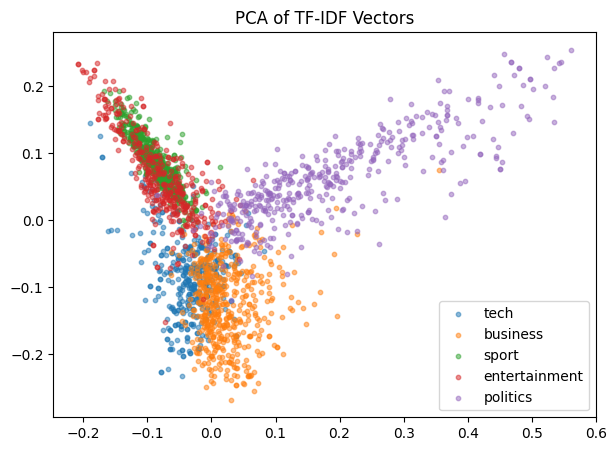

In [20]:
# Hücre 19: PCA ile Görselleştirme
from sklearn.decomposition import PCA
X2d = PCA(n_components=2).fit_transform(X_tfidf.toarray())

plt.figure(figsize=(7,5))
for cat in df['category'].unique():
    idx = y == cat
    plt.scatter(X2d[idx,0], X2d[idx,1], label=cat, alpha=0.5, s=10)
plt.legend(); plt.title("PCA of TF-IDF Vectors"); plt.show()

In [21]:
# Hücre 20: En İyi Modeli Kaydet & Yeni Örnek Tahmin
import joblib
joblib.dump(best_model, "best_text_clf.joblib")

def predict_new(text: str):
    proc = preprocess_text(text)
    return best_model.predict([proc])[0]

print("🎉 New sample prediction:", predict_new("Stock markets fall on economic concerns"))

🎉 New sample prediction: business


In [22]:
# Hücre 21: 5-Fold CV Skoru & Pipeline CV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import FunctionTransformer

cv_scores = cross_val_score(MultinomialNB(alpha=0.1), X_tfidf, y, cv=5, scoring='f1_macro')
print("5-Fold CV f1_macro:", cv_scores.mean().round(4))

# Son olarak Pipeline’ı da tüm veride CV ile test et
pipe_final = Pipeline([
    ("preproc", FunctionTransformer(lambda s: s.apply(preprocess_text))),
    ("tfidf",   TfidfVectorizer(ngram_range=(1,2), max_features=5000, stop_words='english')),
    ("clf",     MultinomialNB(alpha=gs_nb.best_params_['clf__alpha']))
])
print("Pipeline CV accuracy:", cross_val_score(pipe_final, df['text'], df['category'], cv=5, scoring='accuracy').mean().round(4))

5-Fold CV f1_macro: 0.9793
Pipeline CV accuracy: 0.9771
